In [1]:
import os
import pickle
from src.util import plotting_util as putil
import pandas as pd
import fnmatch
from src.util import eval_util as eutil
import seaborn as sns

REPO_DIR = os.path.join(os.getcwd(), "../")
os.chdir(REPO_DIR)

SITES = ["m5", "m8"]
MIG_TYPES = ["mS", "M", "S", "R"]
CUTOFF = 0.8

bins = {}
for x in range(7,15):
    bins[x]=0
for x in range(15,23):
    bins[x]=1
for x in range(23,31):
    bins[x]=2
bins

NOTE: Redirects are currently not supported in Windows or MacOs.


{7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 2,
 24: 2,
 25: 2,
 26: 2,
 27: 2,
 28: 2,
 29: 2,
 30: 2}

29


<Axes: xlabel='clusters', ylabel='Count'>

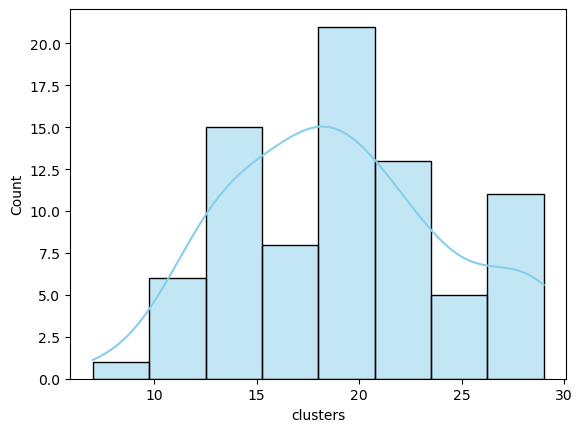

In [2]:
# Get number of clusters (tree vertices to label) per site/mig_type/seed combo
sims_dir = os.path.join(REPO_DIR, "data/machina_sims")
data = []
for site in SITES:
    for mig_type in MIG_TYPES:
        site_mig_type_dir = os.path.join(sims_dir, site, mig_type)
        seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
        seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
        for seed in seeds:
            fn = os.path.join(site_mig_type_dir, f"clustering_observed_seed{seed}.txt")
            num_lines = sum(1 for _ in open(fn))
            fn = os.path.join(site_mig_type_dir, f"T_seed{seed}.labeling")
            sites = set()
            with open(fn) as f:
                for line in f:
                    sites.add(line.strip().split()[1])

            data.append([seed, site, mig_type, num_lines, len(sites)])
            
cols = ["seed", "site", "mig_type", "clusters", "sites"]
cluster_num_df = pd.DataFrame(data, columns=cols)
cluster_num_df["seed"] = cluster_num_df["seed"].astype(int)
print(cluster_num_df['clusters'].max())
sns.histplot(cluster_num_df['clusters'], kde=True, color='skyblue')

In [3]:
cluster_num_df[cluster_num_df['clusters']>20]

,seed,site,mig_type,clusters,sites
9,3,m5,mS,23,6
18,473,m5,M,23,7
42,8,m8,mS,27,9
44,7,m8,mS,21,8
46,5,m8,mS,21,8
47,0,m8,mS,29,9
49,3,m8,mS,28,9
50,241,m8,M,23,8
51,76,m8,M,23,9
52,243,m8,M,28,9


### Evaluate Metient's best trees based on batch size, tree size and number of anatomical sites

In [4]:
batch_sizes = ['16', '32', '64', '128', '512', '1024']

bs_to_num_nodes_to_ground_truth_slns = {bs:{} for bs in batch_sizes}
bs_to_num_sites_to_ground_truth_slns = {bs:{} for bs in batch_sizes}

for bs in batch_sizes:
    prediction_dir = os.path.join(REPO_DIR, 'test', 'machina_simulated_data', 'prediction_outputs', f'predictions_bs_{bs}_gd_08282023')
    print(prediction_dir)
    grad_m5_f1_scores = []
    grad_m8_f1_scores = []
    ct = 0
    tot = 0
    for site in SITES:
        for mig_type in MIG_TYPES:
            true_site_mig_type_data_dir = os.path.join(sims_dir, site, mig_type)
            predicted_site_mig_type_data_dir = os.path.join(prediction_dir, site, mig_type)
            filenames = fnmatch.filter(os.listdir(predicted_site_mig_type_data_dir), 'T_tree*.predicted.tree')
            seeds = set([int(s[s.find("seed")+4:s.find(".predicted")]) for s in filenames])
            for seed in seeds:
                seed_filenames = [f for f in filenames if seed == f[f.find("seed")+4:f.find(".predicted")]]
                # TODO: should we evaluate "top" differently? i.e. top 3 per tree? or 
                #print(site, mig_type, seed)
                tree_info = eutil.get_metient_min_loss_trees(predicted_site_mig_type_data_dir, seed, float("inf"), loss_thres=10.0)
                print(tree_info)
                ground_truth_clones_found = False
                ground_truth_mig_graph_found = False
                Fs, F_G2s = [], []
                for i, (loss, clone_tree_num, met_tree_num) in enumerate(tree_info):
                    
                    metient_pickle_fn = os.path.join(predicted_site_mig_type_data_dir, f"tree{clone_tree_num}_seed{seed}.pickle")
    
                    recall, precision, F, has_resolved_polytomy = eutil.evaluate_seeding_clones(os.path.join(true_site_mig_type_data_dir, f"T_seed{seed}.tree"),
                                                                  os.path.join(true_site_mig_type_data_dir, f"T_seed{seed}.vertex.labeling"),
                                                                  metient_pickle_fn, met_tree_num)
                    
                    if F >= CUTOFF:
                        ground_truth_clones_found = True
    
                    recall_G2, precision_G2, F_G2 = eutil.evaluate_migration_multigraph(os.path.join(true_site_mig_type_data_dir, f"G_seed{seed}.tree"),
                                                                                        metient_pickle_fn, met_tree_num)
                    if F_G2 >= CUTOFF:
                        ground_truth_mig_graph_found = True   
                    Fs.append(F)
                    F_G2s.append(F_G2)
                num_nodes = cluster_num_df[(cluster_num_df['seed']==int(seed))&(cluster_num_df['site']==site)&(cluster_num_df['mig_type']==mig_type)]['clusters'].item()
                rng = bins[num_nodes]
                if rng not in bs_to_num_nodes_to_ground_truth_slns[bs]:
                    bs_to_num_nodes_to_ground_truth_slns[bs][rng] = []
                print(Fs, F_G2s, sum(Fs)/len(Fs), sum(F_G2s)/len(F_G2s))
                if sum(Fs)/len(Fs) < min(Fs):
                    ct += 1
                tot+= 1
                info = (ground_truth_clones_found, ground_truth_mig_graph_found, sum(Fs)/len(Fs), sum(F_G2s)/len(F_G2s))
                bs_to_num_nodes_to_ground_truth_slns[bs][rng].append(info)

                num_sites = cluster_num_df[(cluster_num_df['seed']==int(seed))&(cluster_num_df['site']==site)&(cluster_num_df['mig_type']==mig_type)]['sites'].item()
                if num_sites not in bs_to_num_sites_to_ground_truth_slns[bs]:
                    bs_to_num_sites_to_ground_truth_slns[bs][num_sites] = []
                bs_to_num_sites_to_ground_truth_slns[bs][num_sites].append(info)
                
    print(ct, tot, ct/tot)
bs_to_num_nodes_to_ground_truth_slns


/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/prediction_outputs/predictions_bs_16_gd_08282023
[(96.391, '0', 0), (96.732, '0', 1), (106.166, '1', 0), (106.175, '1', 1)]
[0.8888888888888888, 0.6666666666666666, 1.0, 1.0] [0.8, 0.8, 0.7272727272727273, 0.7272727272727273] 0.8888888888888888 0.7636363636363637
[(87.112, '0', 0), (87.27, '1', 0), (96.924, '2', 0), (97.082, '3', 0), (97.101, '0', 1)]
[1.0, 1.0, 1.0, 1.0, 1.0] [0.6666666666666666, 0.6666666666666666, 0.6000000000000001, 0.6000000000000001, 0.6000000000000001] 1.0 0.6266666666666667
[(102.93, '0', 0), (102.931, '3', 0), (102.94, '1', 0), (102.967, '2', 0)]
[1.0, 1.0, 1.0, 1.0] [0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091] 1.0 0.9090909090909091
[(91.324, '2', 0), (91.341, '1', 0), (100.904, '0', 0), (100.955, '2', 1), (100.959, '1', 1), (100.96, '2', 2)]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.4444444444444

{'16': {1: [(True, True, 0.8888888888888888, 0.7636363636363637),
   (True, True, 0.9226708074534161, 0.7747035573122529),
   (True, False, 0.8859848484848485, 0.5032051282051282),
   (True, True, 0.9743589743589745, 0.7326007326007324),
   (True, False, 0.7058080808080808, 0.5773993808049536),
   (True, True, 0.7991452991452992, 0.5896308819385744),
   (False, True, 0.4901515151515152, 0.6397619047619046),
   (True, True, 1.0, 0.7780219780219781),
   (True, True, 0.5963591963591964, 0.5437611408199644),
   (True, True, 0.8666666666666667, 0.8838383838383838),
   (True, True, 0.9090909090909091, 0.5142857142857142),
   (True, True, 0.7857142857142857, 0.8782051282051282),
   (True, True, 0.8148148148148149, 0.5108780108780109),
   (True, False, 0.8888888888888888, 0.44444444444444453),
   (True, True, 0.5951228258920563, 0.5077073024441451),
   (True, False, 0.7288461538461539, 0.4974358974358974),
   (True, False, 0.8888888888888891, 0.3821428571428571),
   (True, True, 0.874223602484

### Load machina results for comparison

In [5]:
mach_node_size_to_ground_truth_slns = {}
mach_num_sites_to_ground_truth_slns = {}

machina_m5_df, machina_m8_df = eutil.load_machina_results(os.path.join(REPO_DIR, 'test'))
col_mapping = {"FscoreT": "migrating clones F1 score", "FscoreMultiG": "migration graph F1 score", "pattern": "seeding pattern", "seed":"seed"}
machina_m5_df = machina_m5_df.rename(columns=col_mapping)
machina_m8_df = machina_m8_df.rename(columns=col_mapping)
for site, df in zip(['m5', 'm8'],[machina_m5_df, machina_m8_df]):
    for i, row in df.iterrows():
        pattern = row['seeding pattern'].replace("p", "")
        num_nodes = cluster_num_df[(cluster_num_df['seed']==int(row['seed']))&(cluster_num_df['site']==site)&(cluster_num_df['mig_type']==pattern)]['clusters'].item()
        rng = bins[num_nodes]
        num_sites = cluster_num_df[(cluster_num_df['seed']==int(row['seed']))&(cluster_num_df['site']==site)&(cluster_num_df['mig_type']==pattern)]['sites'].item()
        if rng not in mach_node_size_to_ground_truth_slns:
            mach_node_size_to_ground_truth_slns[rng] = []
        if num_sites not in mach_num_sites_to_ground_truth_slns:
            mach_num_sites_to_ground_truth_slns[num_sites] = []
            
        ground_truth_clones_found = False
        ground_truth_mig_graph_found = False
        if float(row['migrating clones F1 score']) >= CUTOFF:
            ground_truth_clones_found = True
        if float(row['migration graph F1 score']) >= CUTOFF:
            ground_truth_mig_graph_found = True
        info = (ground_truth_clones_found, ground_truth_mig_graph_found, row['migrating clones F1 score'], row['migration graph F1 score'])
        mach_node_size_to_ground_truth_slns[rng].append(info)
        mach_num_sites_to_ground_truth_slns[num_sites].append(info)
mach_node_size_to_ground_truth_slns

{1: [(False, False, 0.666666666667, 0.5),
  (False, False, 0.666666666667, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.666666666667),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.666666666667),
  (True, False, 1.0, 0.666666666667),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, True, 1.0, 0.833333333333),
  (True, True, 1.0, 0.833333333333),
  (True, T

In [9]:

def get_merged_results_df(met_dict, mach_dict, x, methods):
    data = []
    for bs in met_dict:
        if f"Metient-{bs}" not in methods: continue
        for key in met_dict[bs]:
            gt_list = met_dict[bs][key]
            percent_true_clones = sum(1 for item in gt_list if item[0]) / len(gt_list) * 100
            percent_true_mig_graph = sum(1 for item in gt_list if item[1]) / len(gt_list) * 100
            avg_clones_f1 = sum(item[2] for item in gt_list) / len(gt_list) * 100
            avg_mig_graph_f1 = sum(item[3] for item in gt_list) / len(gt_list) * 100
            data.append([f"Metient-{bs}", key, avg_clones_f1, avg_mig_graph_f1, percent_true_clones, percent_true_mig_graph])
    
    for key in mach_dict:
        gt_list = mach_dict[key]
        percent_true_clones = sum(1 for item in gt_list if item[0]) / len(gt_list) * 100
        percent_true_mig_graph = sum(1 for item in gt_list if item[1]) / len(gt_list) * 100
        avg_clones_f1 = sum(item[2] for item in gt_list) / len(gt_list) * 100
        avg_mig_graph_f1 = sum(item[3] for item in gt_list) / len(gt_list) * 100
        data.append(["MACHINA", key, avg_clones_f1, avg_mig_graph_f1, percent_true_clones, percent_true_mig_graph])
    results = pd.DataFrame(data, columns=["Method", x, "Migrating clones F1-score", "Migration graph F1-score", "% time that migrating clone ground truth found", "% time that migration graph ground truth found"])
    return results

methods = ["Metient-16", "Metient-32", "Metient-64", "Metient-128", "Metient-512", "Metient-1024"]
results1 = get_merged_results_df(bs_to_num_nodes_to_ground_truth_slns, mach_node_size_to_ground_truth_slns, "Number of Tree Nodes", methods)
results2 = get_merged_results_df(bs_to_num_sites_to_ground_truth_slns, mach_num_sites_to_ground_truth_slns, "Number of Anatomical Sites", methods)
results2

,Method,Number of Anatomical Sites,Migrating clones F1-score,Migration graph F1-score,% time that migrating clone ground truth found,% time that migration graph ground truth found
0,Metient-16,5,81.778,71.142,87.097,83.871
1,Metient-16,6,84.554,64.274,100.000,66.667
2,Metient-16,7,75.370,50.476,100.000,0.000
3,Metient-16,9,78.653,56.479,81.818,18.182
4,Metient-16,8,82.003,67.369,88.462,46.154
5,Metient-16,10,70.065,46.927,100.000,0.000
6,Metient-16,11,98.611,35.891,100.000,100.000
7,Metient-32,5,84.139,73.408,87.097,77.419
8,Metient-32,6,86.407,67.922,100.000,66.667
9,Metient-32,7,75.793,45.936,100.000,33.333


### Make plots for performance as a function of tree size

[(0.96516917, 0.70776351, 0.5606593), (0.95381595, 0.46373781, 0.31769923), (0.8833417, 0.19830556, 0.26014181), (0.67824099, 0.09192342, 0.3504148), (0.43860848, 0.12177004, 0.34119475), (0.20973515, 0.09747934, 0.24238489), (0.18, 0.54, 0.34)]


/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


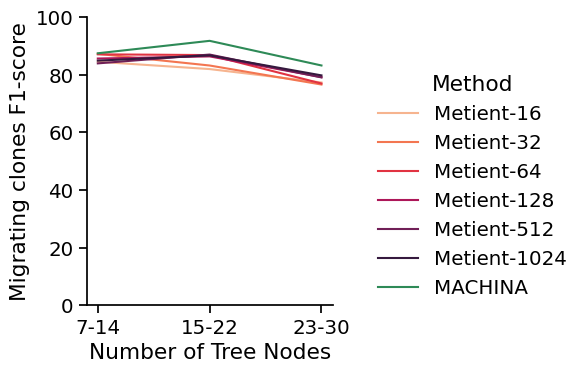

/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


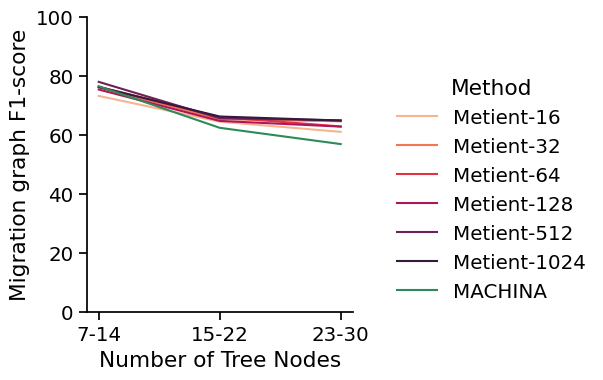

/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


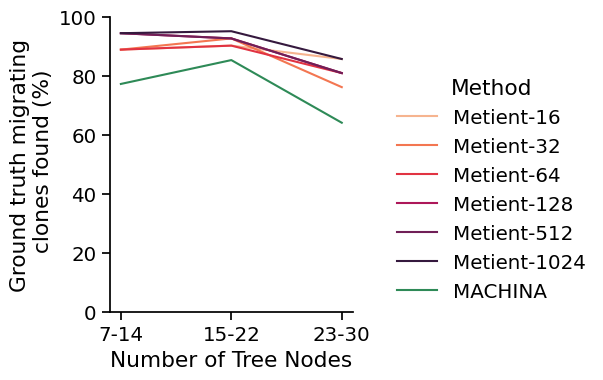

/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


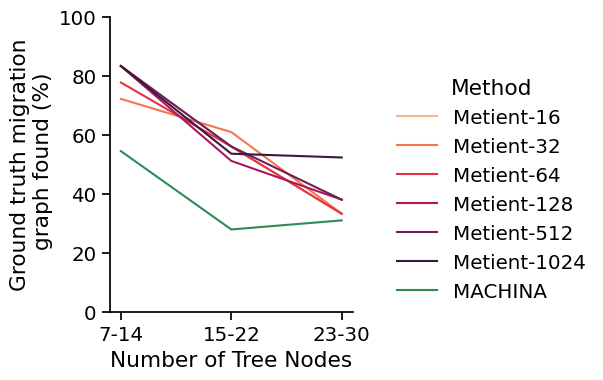

/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


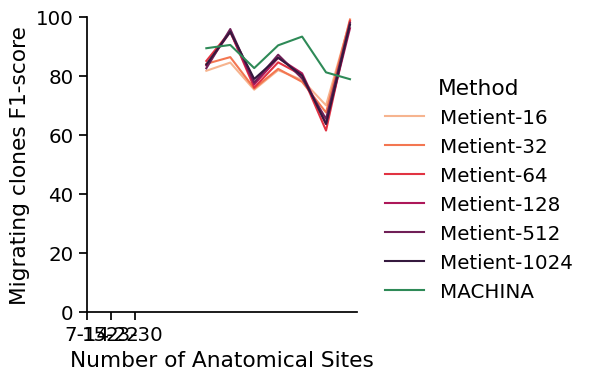

/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


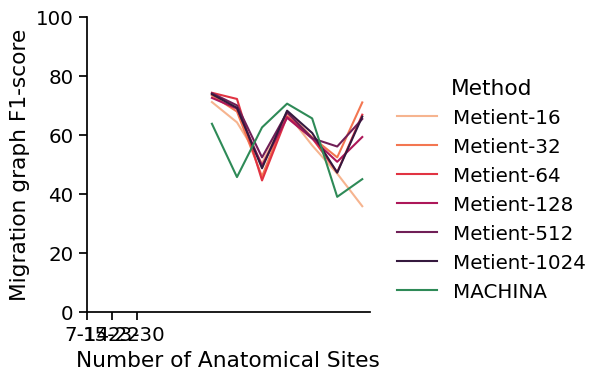

/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


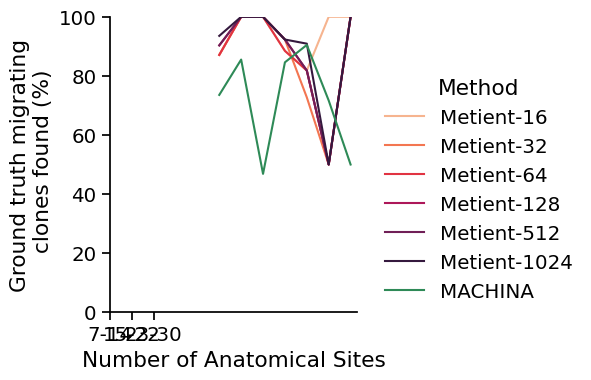

/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


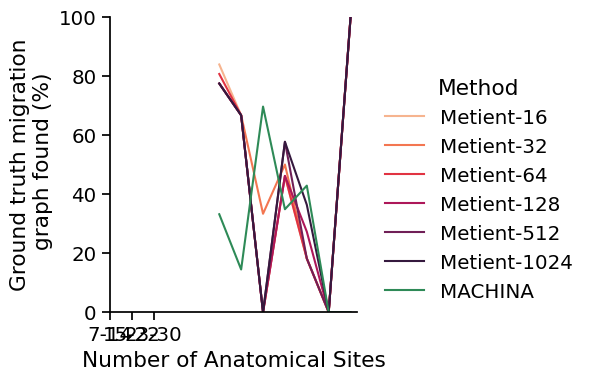

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette("rocket")
colors.reverse()
colors = colors[:len(methods)]
colors.append((0.18, 0.54, 0.34))
print(colors)
sns.set_palette(sns.color_palette(colors))
ys = ["Migrating clones F1-score", "Migration graph F1-score", "% time that migrating clone ground truth found", "% time that migration graph ground truth found"]
y_labels = ["Migrating clones F1-score", "Migration graph F1-score", "Ground truth migrating\n clones found (%)", "Ground truth migration\n graph found (%)"]

for x, df in zip(["Number of Tree Nodes", "Number of Anatomical Sites"], [results1, results2]):
    for i,y in enumerate(ys):
        with sns.plotting_context("notebook", font_scale=1.3):
            g = sns.relplot(
                data=df, x=x, y=y,
                height=4, aspect=1.0, dashes=False,
                hue="Method", style="Method", kind="line", errorbar='sd', legend=True,
            )
            labels = ['7-14', '15-22', '23-30']
            plt.xticks(ticks=[0.0,1.0,2.0],labels=['7-14', '15-22', '23-30'])
            (g.set_axis_labels(x, y_labels[i])
              .set_titles("boop")
              .tight_layout(w_pad=0))
            plt.ylim(0, 100)
            
           # plt.legend(title='', loc='upper left', labels=['Metient', 'Metient CI (1 SD)', "MACHINA", "MACHINA CI (1 SD)"], prop={'size': 10}, frameon=False)
            plt.show()
        
            fig = g.fig
            out_name = ("_").join(y_labels[i].split(" ") + x.split(" "))
            fig.savefig(os.path.join(REPO_DIR, "test", f"{out_name}.png"), dpi=600) 
